# Assignment 1 - TD with State Aggregation

Welcome to your Course 3 Programming Assignment 1. In this assignment, you will implement **semi-gradient TD(0) with State Aggregation** in an environment with a large state space. This assignment will focus on the **policy evaluation task** (prediction problem) where the goal is to accurately estimate state values under a given (fixed) policy.


**In this assignment, you will:**
1. Implement semi-gradient TD(0) with function approximation (state aggregation).
2. Understand how to use supervised learning approaches to approximate value functions.
3. Compare the impact of different resolutions of state aggregation, and see first hand how function approximation can speed up learning through generalization.

**Note: You can create new cells for debugging purposes but please do not duplicate any Read-only cells. This may break the grader.**

## 500-State RandomWalk Environment

In this assignment, we will implement and use a smaller 500 state  version of the problem we covered in lecture  (see "State Aggregation with Monte Carlo”, and Example 9.1 in the [textbook](http://www.incompleteideas.net/book/RLbook2018.pdf)). The diagram below illustrates the problem.

![](data/randomwalk_diagram.png)

There are 500 states numbered from 1 to 500, left to right, and all episodes begin with the agent located at the center, in state 250. For simplicity, we will consider state 0 and state 501 as the left and right terminal states respectively. 

The episode terminates when the agent reaches the terminal state (state 0) on the left, or the terminal state (state 501) on the right. Termination on the left (state 0) gives the agent a reward of -1, and termination on the right (state 501) gives the agent a reward of +1.

The agent can take one of two actions: go left or go right. If the agent chooses the left action, then it transitions uniform randomly into one of the 100 neighboring states to its left. If the agent chooses the right action, then it transitions randomly into one of the 100 neighboring states to its right. 

States near the edge may have fewer than 100 neighboring states on that side. In this case, all transitions that would have taken the agent past the edge result in termination. If the agent takes the left action from state 50, then it has a 0.5 chance of terminating on the left. If it takes the right action from state 499, then it has a 0.99 chance of terminating on the right.


### Your Goal

For this assignment, we will consider the problem of **policy evaluation**: estimating state-value function for a fixed policy.You will evaluate a uniform random policy in the 500-State Random Walk environment. This policy takes the right action with 0.5 probability and the left with 0.5 probability, regardless of which state it is in. 

This environment has a relatively large number of states. Generalization can significantly speed learning as we will show in this assignment. Often in realistic environments, states are high-dimensional and continuous. For these problems, function approximation is not just useful, it is also necessary.

## Packages

You will use the following packages in this assignment.

- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.
- [RL-Glue](http://www.jmlr.org/papers/v10/tanner09a.html) : Library for reinforcement learning experiments.
- [jdc](https://alexhagen.github.io/jdc/) : Jupyter magic that allows defining classes over multiple jupyter notebook cells.
- [tqdm](https://tqdm.github.io/) : A package to display progress bar when running experiments
- plot_script : custom script to plot results

**Please do not import other libraries** — this will break the autograder.


In [1]:
# Do not modify this cell!

# Import necessary libraries
# DO NOT IMPORT OTHER LIBRARIES - This will break the autograder.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import jdc
from tqdm import tqdm

from rl_glue import RLGlue
from environment import BaseEnvironment
from agent import BaseAgent
import plot_script

## Section 1: Create the 500-State RandomWalk Environment

In this section we have provided you with the implementation of the 500-State RandomWalk Environment. It is useful to know how the environment is implemented. We will also use this environment in the next programming assignment. 

Once the agent chooses which direction to move, the environment determines how far the agent is moved in that direction. Assume the agent passes either 0 (indicating left) or 1 (indicating right) to the environment.

Methods needed to implement the environment are: `env_init`, `env_start`, and `env_step`.

- `env_init`: This method sets up the environment at the very beginning of the experiment. Relevant parameters are passed through `env_info` dictionary.
- `env_start`: This is the first method called when the experiment starts, returning the start state.
- `env_step`: This method takes in action and returns reward, next_state, and is_terminal.

In [2]:
# Do not modify this cell!

class RandomWalkEnvironment(BaseEnvironment):
    def env_init(self, env_info={}):
        """
        Setup for the environment called when the experiment first starts.
        
        Set parameters needed to setup the 500-state random walk environment.
        
        Assume env_info dict contains:
        {
            num_states: 500 [int],
            start_state: 250 [int],
            left_terminal_state: 0 [int],
            right_terminal_state: 501 [int],
            seed: int
        }
        """
        
        # set random seed for each run
        self.rand_generator = np.random.RandomState(env_info.get("seed")) 
        
        # set each class attribute
        self.num_states = env_info["num_states"] 
        self.start_state = env_info["start_state"] 
        self.left_terminal_state = env_info["left_terminal_state"] 
        self.right_terminal_state = env_info["right_terminal_state"]

    def env_start(self):
        """
        The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state from the environment.
        """

        # set self.reward_state_term tuple
        reward = 0.0
        state = self.start_state
        is_terminal = False
                
        self.reward_state_term = (reward, state, is_terminal)
        
        # return first state from the environment
        return self.reward_state_term[1]
        
    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state,
                and boolean indicating if it's terminal.
        """
        
        last_state = self.reward_state_term[1]
        
        # set reward, current_state, and is_terminal
        #
        # action: specifies direction of movement - 0 (indicating left) or 1 (indicating right)  [int]
        # current state: next state after taking action from the last state [int]
        # reward: -1 if terminated left, 1 if terminated right, 0 otherwise [float]
        # is_terminal: indicates whether the episode terminated [boolean]
        #
        # Given action (direction of movement), determine how much to move in that direction from last_state
        # All transitions beyond the terminal state are absorbed into the terminal state.
        
        if action == 0: # left
            current_state = max(self.left_terminal_state, last_state + self.rand_generator.choice(range(-100,0)))
        elif action == 1: # right
            current_state = min(self.right_terminal_state, last_state + self.rand_generator.choice(range(1,101)))
        else: 
            raise ValueError("Wrong action value")
        
        # terminate left
        if current_state == self.left_terminal_state: 
            reward = -1.0
            is_terminal = True
        
        # terminate right
        elif current_state == self.right_terminal_state:
            reward = 1.0
            is_terminal = True
        
        else:
            reward = 0.0
            is_terminal = False
        
        self.reward_state_term = (reward, current_state, is_terminal)
        
        return self.reward_state_term
        

## Section 2: Create Semi-gradient TD(0) Agent with State Aggregation

Now let's create the Agent that interacts with the Environment.

You will create an Agent that learns with semi-gradient TD(0) with state aggregation.
For state aggregation, if the resolution (num_groups) is 10, then 500 states are partitioned into 10 groups of 50 states each (i.e., states 1-50 are one group, states 51-100 are another, and so on.)

Hence, 50 states would share the same feature and value estimate, and there would be 10 distinct features. The feature vector for each state is a one-hot feature vector of length 10, with a single one indicating the group for that state. (one-hot vector of length 10)

## Section 2-1: Implement Useful Functions

Before we implement the agent, we need to define a couple of useful helper functions.

**Please note all random method calls should be called through random number generator. Also do not use random method calls unless specified. In the agent, only `agent_policy` requires random method calls.**

## Section 2-1a: Selecting actions

In this part we have implemented `agent_policy()` for you.

This method is used in `agent_start()` and `agent_step()` to select appropriate action.
Normally, the agent acts differently given state, but in this environment the agent chooses randomly to move either left or right with equal probability.

Agent returns 0 for left, and 1 for right.

In [3]:
# Do not modify this cell!

def agent_policy(rand_generator, state):
    """
    Given random number generator and state, returns an action according to the agent's policy.
    
    Args:
        rand_generator: Random number generator

    Returns:
        chosen action [int]
    """
    
    # set chosen_action as 0 or 1 with equal probability
    # state is unnecessary for this agent policy
    chosen_action = rand_generator.choice([0,1])
    
    return chosen_action

Run the following code to verify `agent_policy`. Expected output should match since we are controlling the random seed. Verify that actions 0 and 1 are chosen equally randomly.

In [4]:
# Do not modify this cell!

## Test Code for agent_policy() ##

test_rand_generator = np.random.RandomState(99) 
state = 250

action_array = []
for i in range(10):
    action_array.append(agent_policy(test_rand_generator, 250))
    
print('action_array: {}'.format(action_array))

action_array: [1, 1, 1, 0, 1, 0, 0, 0, 1, 0]


  **Expected output**:
  
action_array: [1, 1, 1, 0, 1, 0, 0, 0, 1, 0]


## Section 2-1b: Processing State Features with State Aggregation

In this part you will implement `get_state_feature()`

This method takes in a state and returns the aggregated feature (one-hot-vector) of that state.
The feature vector size is determined by `num_groups`. Use `state` and `num_states_in_group` to determine which element in the feature vector is active.

`get_state_feature()` is necessary whenever the agent receives a state and needs to convert it to a feature for learning. The features will thus be used in `agent_step()` and `agent_end()` when the agent updates its state values.

In [5]:
# [Graded]

def get_state_feature(num_states_in_group, num_groups, state):
    """
    Given state, return the feature of that state
    
    Args:
        num_states_in_group [int]
        num_groups [int] 
        state [int] : 1~500

    Returns:
        one_hot_vector [numpy array]
    """
    
    ### Generate state feature (2~4 lines)
    # Create one_hot_vector with size of the num_groups, according to state
    # For simplicity, assume num_states is always perfectly divisible by num_groups
    # Note that states start from index 1, not 0!
    
    # Example:
    # If num_states = 100, num_states_in_group = 20, num_groups = 5,
    # one_hot_vector would be of size 5.
    # For states 1~20, one_hot_vector would be: [1, 0, 0, 0, 0]
    # 
    # one_hot_vector = ?
    
    ### START CODE HERE ###
    one_hot_vector = np.zeros(num_groups)
    one_hot_vector[(state-1) // num_states_in_group] = 1
    ### END CODE HERE ###
    
    return one_hot_vector


Run the following code to verify your `get_state_feature()` function.

In [6]:
# Do not modify this cell!

## Test Code for get_state_feature() ##

# Given that num_states = 10 and num_groups = 5, test get_state_feature()
# There are states 1~10, and the state feature vector would be of size 5.
# Only one element would be active for any state feature vector.

# get_state_feature() should support various values of num_states, num_groups, not just this example
# For simplicity, assume num_states will always be perfectly divisible by num_groups
num_states = 10
num_groups = 5
num_states_in_group = int(num_states / num_groups)

# Test 1st group, state = 1
state = 1
print("1st group: {}".format(get_state_feature(num_states_in_group, num_groups, state)))

# Test 2nd group, state = 3
state = 3
print("2nd group: {}".format(get_state_feature(num_states_in_group, num_groups, state)))

# Test 3rd group, state = 6
state = 6
print("3rd group: {}".format(get_state_feature(num_states_in_group, num_groups, state)))

# Test 4th group, state = 7
state = 7
print("4th group: {}".format(get_state_feature(num_states_in_group, num_groups, state)))

# Test 5th group, state = 10
state = 10
print("5th group: {}".format(get_state_feature(num_states_in_group, num_groups, state)))


1st group: [1. 0. 0. 0. 0.]
2nd group: [0. 1. 0. 0. 0.]
3rd group: [0. 0. 1. 0. 0.]
4th group: [0. 0. 0. 1. 0.]
5th group: [0. 0. 0. 0. 1.]


  **Expected output**:
  
    1st group: [1. 0. 0. 0. 0.]
    2nd group: [0. 1. 0. 0. 0.]
    3rd group: [0. 0. 1. 0. 0.]
    4th group: [0. 0. 0. 1. 0.]
    5th group: [0. 0. 0. 0. 1.]

## Section 2-2: Implement Agent Methods

Now that we have implemented all the helper functions, let's create an agent. In this part, you will implement `agent_init()`, `agent_start()`, `agent_step()` and `agent_end()`. You will have to use `agent_policy()` that we implemented above. We will implement `agent_message()` later, when returning the learned state-values.

To save computation time, we precompute features for all states beforehand in `agent_init()`. The pre-computed features are saved in `self.all_state_features` numpy array. Hence, you do not  need to call `get_state_feature()` every time in `agent_step()` and `agent_end()`.

The shape of `self.all_state_features` numpy array is `(num_states, feature_size)`, with features of states from State 1-500. Note that index 0 stores features for State 1 (Features for State 0 does not exist). Use `self.all_state_features` to access each feature vector for a state.

When saving state values in the agent, recall how the state values are represented with linear function approximation.

**State Value Representation**: $\hat{v}(s,\mathbf{w}) = \mathbf{w}\cdot\mathbf{x^T}$ where $\mathbf{w}$ is a weight vector and $\mathbf{x}$ is the feature vector of the state.


When performing TD(0) updates with Linear Function Approximation, recall how we perform semi-gradient TD(0) updates using supervised learning.

**semi-gradient TD(0) Weight Update Rule**: $\mathbf{w_{t+1}} = \mathbf{w_{t}} + \alpha [R_{t+1} + \gamma \hat{v}(S_{t+1},\mathbf{w}) - \hat{v}(S_t,\mathbf{w})] \nabla \hat{v}(S_t,\mathbf{w})$

In [7]:
# [Graded]

# Create TDAgent
class TDAgent(BaseAgent):
    def __init__(self):
        self.num_states = None
        self.num_groups = None
        self.step_size = None
        self.discount_factor = None
        
    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the semi-gradient TD(0) state aggregation agent.

        Assume agent_info dict contains:
        {
            num_states: 500 [int],
            num_groups: int, 
            step_size: float, 
            discount_factor: float,
            seed: int
        }
        """

        # set random seed for each run
        self.rand_generator = np.random.RandomState(agent_info.get("seed")) 

        # set class attributes
        self.num_states = agent_info.get("num_states")
        self.num_groups = agent_info.get("num_groups")
        self.step_size = agent_info.get("step_size")
        self.discount_factor = agent_info.get("discount_factor")

        # pre-compute all observable features
        num_states_in_group = int(self.num_states / self.num_groups)
        self.all_state_features = np.array([get_state_feature(num_states_in_group, self.num_groups, state) for state in range(1, self.num_states + 1)])

        ### initialize weights correctly (1 line)
        # initialize all weights to zero using numpy array with correct size
        # self.weights = ?

        ### START CODE HERE ###
        self.weights = np.zeros(self.num_groups)
        ### END CODE HERE ###

        self.last_state = None
        self.last_action = None

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            self.last_action [int] : The first action the agent takes.
        """

        ### select action given state (using agent_policy), and save current state and action (2~3 lines)
        # Use self.rand_generator for agent_policy
        # 
        # self.last_state = ?
        # self.last_action = ?

        ### START CODE HERE ###
        action = agent_policy(self.rand_generator, state)
        self.last_state = state
        self.last_action = action
        ### END CODE HERE ###

        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward [float]: the reward received for taking the last action taken
            state [int]: the state from the environment's step, where the agent ended up after the last step
        Returns:
            self.last_action [int] : The action the agent is taking.
        """
        
        # get relevant feature
        current_state_feature = self.all_state_features[state-1] 
        last_state_feature = self.all_state_features[self.last_state-1] 
        
        ### update weights and select action (3~5 lines)
        # (Hint: np.dot method is useful!)
        #
        # Update weights:
        #     use self.weights, current_state_feature, and last_state_feature
        #
        # Select action:
        #     use self.rand_generator for agent_policy
        #
        # Current state and selected action should be saved to self.last_state and self.last_action at the end
        #
        # self.weights = ?
        # self.last_state = ?
        # self.last_action = ?

        ### START CODE HERE ###
        self.weights += self.step_size * (reward + self.discount_factor * np.dot(self.weights, current_state_feature) - np.dot(self.weights, last_state_feature)) * last_state_feature
        action = agent_policy(self.rand_generator, state)
        self.last_state = state
        self.last_action = action
        ### END CODE HERE ###
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        # get relevant feature
        last_state_feature = self.all_state_features[self.last_state-1]
        
        ### update weights (1~2 lines)
        # Update weights using self.weights and last_state_feature
        # (Hint: np.dot method is useful!)
        # 
        # Note that here you don't need to choose action since the agent has reached a terminal state
        # Therefore you should not update self.last_state and self.last_action
        # 
        # self.weights = ?
        
        ### START CODE HERE ###
        self.weights += self.step_size * (reward - np.dot(self.weights, last_state_feature)) * last_state_feature
        ### END CODE HERE ###
        return
        
    def agent_message(self, message):
        # We will implement this method later
        raise NotImplementedError



Run the following code to verify `agent_init()`

In [8]:
# Do not modify this cell!

## Test Code for agent_init() ## 

agent_info = {"num_states": 500,
              "num_groups": 10,
              "step_size": 0.1,
              "discount_factor": 1.0,
              "seed": 1}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# check attributes
print("num_states: {}".format(test_agent.num_states))
print("num_groups: {}".format(test_agent.num_groups))
print("step_size: {}".format(test_agent.step_size))
print("discount_factor: {}".format(test_agent.discount_factor))

print("weights shape: {}".format(test_agent.weights.shape))
print("weights init. value: {}".format(test_agent.weights))


num_states: 500
num_groups: 10
step_size: 0.1
discount_factor: 1.0
weights shape: (10,)
weights init. value: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


  **Expected output**:
  
    num_states: 500
    num_groups: 10
    step_size: 0.1
    discount_factor: 1.0
    weights shape: (10,)
    weights init. value: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Run the following code to verify `agent_start()`.
Although there is randomness due to `rand_generator.choice()` in `agent_policy()`, we control the seed so your output should match the expected output. 

Make sure `rand_generator.choice()` is called only once per `agent_policy()` call.

In [9]:
# Do not modify this cell!
## Test Code for agent_start() and agent_policy() ## 

agent_info = {"num_states": 500,
              "num_groups": 10,
              "step_size": 0.1,
              "discount_factor": 1.0,
              "seed": 1
             }

# Suppose state = 250
state = 250

test_agent = TDAgent()
test_agent.agent_init(agent_info)
test_agent.agent_start(state)

print("Agent state: {}".format(test_agent.last_state))
print("Agent selected action: {}".format(test_agent.last_action))


Agent state: 250
Agent selected action: 1


**Expected output**:

    Agent state: 250
    Agent selected action: 1

Run the following code to verify `agent_step()`


In [10]:
# Do not modify this cell!

## Test Code for agent_step() ## 
# Make sure agent_init() and agent_start() are working correctly first.
# agent_step() should work correctly for other arbitrary state transitions in addition to this test case.
agent_info = {"num_states": 500,
              "num_groups": 10,
              "step_size": 0.1,
              "discount_factor": 0.9,
              "seed": 1}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# Initializing the weights to arbitrary values to verify the correctness of weight update
test_agent.weights = np.array([-1.5, 0.5, 1., -0.5, 1.5, -0.5, 1.5, 0.0, -0.5, -1.0])
print("Initial weights: {}".format(test_agent.weights))

# Assume the agent started at State 50
start_state = 50
action = test_agent.agent_start(start_state)

# Assume the reward was 10.0 and the next state observed was State 120
reward = 10.0
next_state = 120
test_agent.agent_step(reward, next_state)
print("Updated weights: {}".format(test_agent.weights))

if np.allclose(test_agent.weights, np.array([-0.26, 0.5, 1., -0.5, 1.5, -0.5, 1.5, 0., -0.5, -1.])):
    print("weight update is correct!\n")
else:
    print("weight update is incorrect.\n")

print("last state: {}".format(test_agent.last_state))
print("last action: {}".format(test_agent.last_action))


Initial weights: [-1.5  0.5  1.  -0.5  1.5 -0.5  1.5  0.  -0.5 -1. ]
Updated weights: [-0.26  0.5   1.   -0.5   1.5  -0.5   1.5   0.   -0.5  -1.  ]
weight update is correct!

last state: 120
last action: 1


**Expected output**: (Note only the 1st element was changed)
    
    Initial weights: [-1.5  0.5  1.  -0.5  1.5 -0.5  1.5  0.  -0.5 -1. ]
    Updated weights: [-0.26  0.5   1.   -0.5   1.5  -0.5   1.5   0.   -0.5  -1.  ]
    last state: 120
    last action: 1

Run the following code to verify `agent_end()`

In [11]:
# Do not modify this cell!

## Test Code for agent_end() ## 
# Make sure agent_init() and agent_start() are working correctly first.

agent_info = {"num_states": 500,
              "num_groups": 10,
              "step_size": 0.1,
              "discount_factor": 0.9,
              "seed": 1}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# Initializing the weights to arbitrary values to verify the correctness of weight update
test_agent.weights = np.array([-1.5, 0.5, 1., -0.5, 1.5, -0.5, 1.5, 0.0, -0.5, -1.0])
print("Initial weights: {}".format(test_agent.weights))

# Assume the agent started at State 50
start_state = 50
test_agent.agent_start(start_state)

# Assume the reward was 10.0 and reached the terminal state
test_agent.agent_end(10.0)
print("Updated weights: {}".format(test_agent.weights))

if np.allclose(test_agent.weights, np.array([-0.35, 0.5, 1., -0.5, 1.5, -0.5, 1.5, 0., -0.5, -1.])):
    print("weight update is correct!\n")
else:
    print("weight update is incorrect.\n")
    

Initial weights: [-1.5  0.5  1.  -0.5  1.5 -0.5  1.5  0.  -0.5 -1. ]
Updated weights: [-0.35  0.5   1.   -0.5   1.5  -0.5   1.5   0.   -0.5  -1.  ]
weight update is correct!



**Expected output**: (Note only the 1st element was changed, and the result is different from `agent_step()` )
    
    Initial weights: [-1.5  0.5  1.  -0.5  1.5 -0.5  1.5  0.  -0.5 -1. ]
    Updated weights: [-0.35  0.5   1.   -0.5   1.5  -0.5   1.5   0.   -0.5  -1.  ]

## Section 2-3: Returning Learned State Values

You are almost done! Now let's implement a code block in `agent_message()` that returns the learned state values.

The method `agent_message()` will return the learned state_value array when `message == 'get state value'`.

**Hint**: Think about how state values are represented with linear function approximation. `state_value` array will be a 1D array with length equal to the number of states.

In [12]:
%%add_to TDAgent
# [Graded]

def agent_message(self, message):
    if message == 'get state value':
        
        ### return state_value (1~2 lines)
        # Use self.all_state_features and self.weights to return the vector of all state values
        # Hint: Use np.dot()
        #
        # state_value = ?
        
        ### START CODE HERE ###
        state_value = np.dot(self.weights, self.all_state_features.T)
        ### END CODE HERE ###
        
        return state_value

Run the following code to verify `get_state_val()`

In [13]:
# Do not modify this cell!

## Test Code for agent_get_state_val() ##

agent_info = {"num_states": 20,
              "num_groups": 5,
              "step_size": 0.1,
              "discount_factor": 1.0}

test_agent = TDAgent()
test_agent.agent_init(agent_info)
test_state_val = test_agent.agent_message('get state value')

print("State value shape: {}".format(test_state_val.shape))
print("Initial State value for all states: {}".format(test_state_val))



State value shape: (20,)
Initial State value for all states: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


**Expected Output**:

    State value shape: (20,)
    Initial State value for all states: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

## Section 3: Run Experiment

Now that we've implemented all the components of environment and agent, let's run an experiment! We will plot two things: (1) the learned state value function and compare it against the true state values, and (2) a learning curve depicting the error in the learned value estimates over episodes. For the learning curve, what should we plot to see if the agent is learning well?

## Section 3-1: Prediction Objective (Root Mean Squared Value Error) 

Recall that the Prediction Objective in function approximation is Mean Squared Value Error $\overline{VE}(\mathbf{w}) \doteq \sum\limits_{s \in \mathcal{S}}\mu(s)[v_\pi(s)-\hat{v}(s,\mathbf{w})]^2$

We will use the square root of this measure, the root $\overline{VE}$ to give a rough measure of how much the learned values differ from the true values.

`calc RMSVE()` computes the Root Mean Squared Value Error given learned state value $\hat{v}(s, \mathbf{w})$.
We provide you with true state value $v_\pi(s)$ and state distribution $\mu(s)$


In [14]:
# Do not modify this cell!

# Here we provide you with the true state value and state distribution
true_state_val = np.load('data/true_V.npy')    
state_distribution = np.load('data/state_distribution.npy')

def calc_RMSVE(learned_state_val):
    assert(len(true_state_val) == len(learned_state_val) == len(state_distribution))
    MSVE = np.sum(np.multiply(state_distribution, np.square(true_state_val - learned_state_val)))
    RMSVE = np.sqrt(MSVE)
    return RMSVE

## Section 3-2a: Run Experiment with 10-State Aggregation

We have provided you the experiment/plot code in the cell below.

In [15]:
# Do not modify this cell!

# Define function to run experiment
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):

    rl_glue = RLGlue(environment, agent)
    
    # Sweep Agent parameters
    for num_agg_states in agent_parameters["num_groups"]:
        for step_size in agent_parameters["step_size"]:
            
            # save rmsve at the end of each evaluation episode
            # size: num_episode / episode_eval_frequency + 1 (includes evaluation at the beginning of training)
            agent_rmsve = np.zeros(int(experiment_parameters["num_episodes"]/experiment_parameters["episode_eval_frequency"]) + 1)
            
            # save learned state value at the end of each run
            agent_state_val = np.zeros(environment_parameters["num_states"])

            env_info = {"num_states": environment_parameters["num_states"],
                        "start_state": environment_parameters["start_state"],
                        "left_terminal_state": environment_parameters["left_terminal_state"],
                        "right_terminal_state": environment_parameters["right_terminal_state"]}

            agent_info = {"num_states": environment_parameters["num_states"],
                          "num_groups": num_agg_states,
                          "step_size": step_size,
                          "discount_factor": environment_parameters["discount_factor"]}

            print('Setting - num. agg. states: {}, step_size: {}'.format(num_agg_states, step_size))
            os.system('sleep 0.2')
            
            # one agent setting
            for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
                env_info["seed"] = run
                agent_info["seed"] = run
                rl_glue.rl_init(agent_info, env_info)
                
                # Compute initial RMSVE before training
                current_V = rl_glue.rl_agent_message("get state value")
                agent_rmsve[0] += calc_RMSVE(current_V)
                    
                for episode in range(1, experiment_parameters["num_episodes"]+1):
                    # run episode
                    rl_glue.rl_episode(0) # no step limit
                    
                    if episode % experiment_parameters["episode_eval_frequency"] == 0:
                        current_V = rl_glue.rl_agent_message("get state value")
                        agent_rmsve[int(episode/experiment_parameters["episode_eval_frequency"])] += calc_RMSVE(current_V)
                        
                # store only one run of state value
                if run == 50:
                    agent_state_val = rl_glue.rl_agent_message("get state value")
            
            # rmsve averaged over runs
            agent_rmsve /= experiment_parameters["num_runs"]
            
            save_name = "{}_agg_states_{}_step_size_{}".format('TD_agent', num_agg_states, step_size).replace('.','')
            
            if not os.path.exists('results'):
                os.makedirs('results')
    
            # save avg. state value
            np.save("results/V_{}".format(save_name), agent_state_val)

            # save avg. rmsve
            np.save("results/RMSVE_{}".format(save_name), agent_rmsve)


We will first test our implementation using state aggregation with resolution of 10, with three different step sizes: {0.01, 0.05, 0.1}.

Note that running the experiment cell below will take **_approximately 5 min_**.


Setting - num. agg. states: 10, step_size: 0.01


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


Setting - num. agg. states: 10, step_size: 0.05


100%|██████████| 50/50 [01:03<00:00,  1.26s/it]


Setting - num. agg. states: 10, step_size: 0.1


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


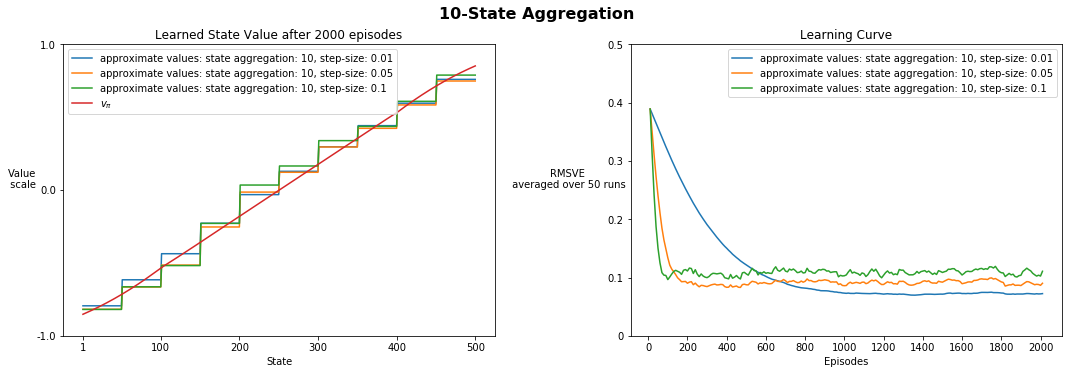

In [16]:
# Do not modify this cell!

#### Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 50,
    "num_episodes" : 2000,
    "episode_eval_frequency" : 10 # evaluate every 10 episodes
}

# Environment parameters
environment_parameters = {
    "num_states" : 500, 
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501, 
    "discount_factor" : 1.0
}

# Agent parameters
# Each element is an array because we will be later sweeping over multiple values
agent_parameters = {
    "num_groups": [10],
    "step_size": [0.01, 0.05, 0.1]
}

current_env = RandomWalkEnvironment
current_agent = TDAgent

run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_script.plot_result(agent_parameters, 'results')

Is the learned state value plot with step-size=0.01 similar to Figure 9.2 (p.208) in Sutton and Barto?

(Note that our environment has less states: 500 states and we have done 2000 episodes, and averaged the performance over 50 runs)

Look at  the plot of the learning curve. Does RMSVE decrease over time?

Would it be possible to reduce RMSVE to 0?

You should see the RMSVE decrease over time, but the error seems to plateau. It is impossible to reduce RMSVE to 0, because of function approximation (and we do not decay the step-size parameter to zero). With function approximation, the agent has limited resources and has to trade-off the accuracy of one state for another state.

Run the following code to verify your experimental result.

In [17]:
# Do not modify this cell!

## Test Code for experimental result##

agent_parameters = {
    "num_groups": [10],
    "step_size": [0.01, 0.05, 0.1]
}

all_correct = True
for num_agg_states in agent_parameters["num_groups"]:
    for step_size in agent_parameters["step_size"]:
        filename = 'RMSVE_TD_agent_agg_states_{}_step_size_{}'.format(num_agg_states, step_size).replace('.','')
        agent_RMSVE = np.load('results/{}.npy'.format(filename))
        correct_RMSVE = np.load('correct_npy/{}.npy'.format(filename))

        if not np.allclose(agent_RMSVE, correct_RMSVE):
            all_correct=False

if all_correct:
    print("Your experiment results are correct!")
else:
    print("Your experiment results does not match with ours. Please check if you have implemented all methods correctly.")

Your experiment results are correct!


## Section 3-2b: Run Experiment with Different State Aggregation Resolution and Step-Size

In this section, we will run some more experiments to see how different parameter settings affect the results!

In particular, we will test several values of `num_groups` and `step_size`. Parameter sweeps although necessary, can take lots of time. So now that you have verified your experiment result, here we show you the results of the parameter sweeps that you would see when running the sweeps yourself.

We tested several different values of `num_groups`: {10, 100, 500}, and `step-size`: {0.01, 0.05, 0.1}. As before, we performed 2000 episodes per run, and averaged the results over 50 runs for each setting.

Run the cell below to display the sweep results.


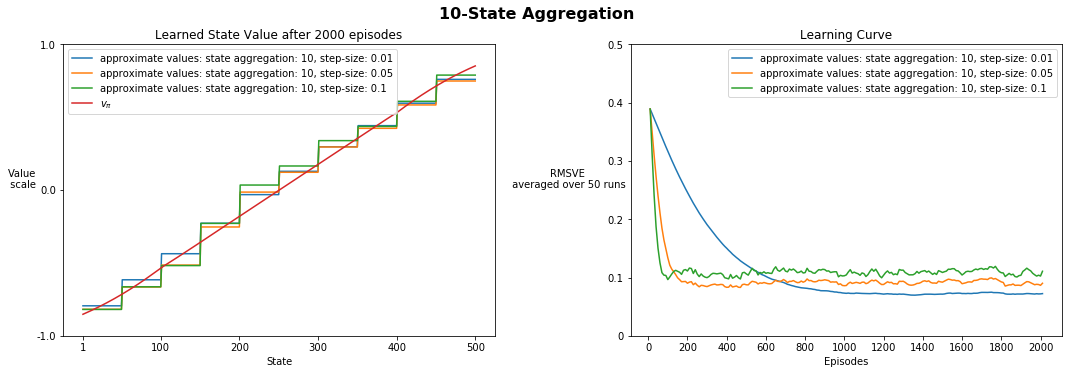

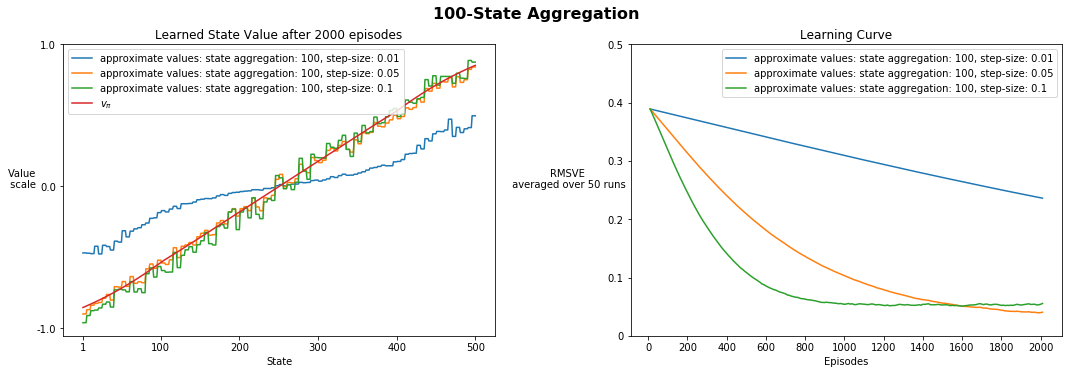

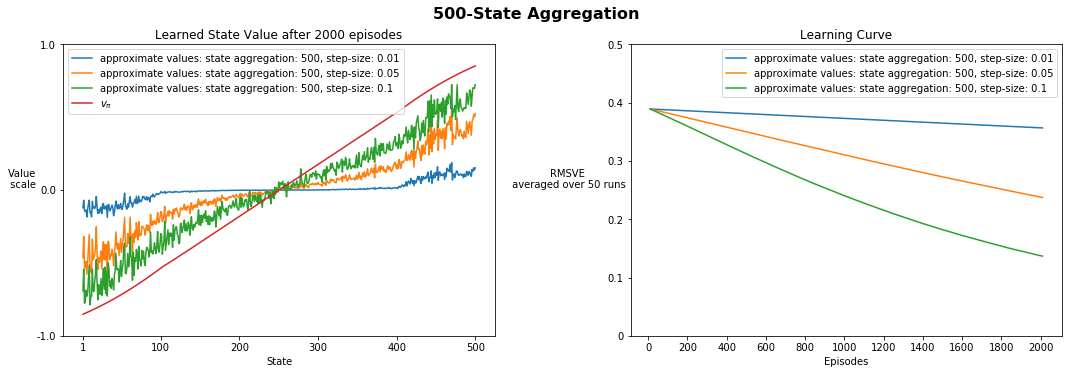

In [18]:
#### Display result with parameter sweeps

# Make sure to verify your experiment result with the test cell above.
# Otherwise the sweep results will not be displayed.

# Experiment parameters
experiment_parameters = {
    "num_runs" : 50,
    "num_episodes" : 2000,
    "episode_eval_frequency" : 10 # evaluate every 10 episodes
}

# Environment parameters
environment_parameters = {
    "num_states" : 500,
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501,
    "discount_factor" : 1.0
}

# Agent parameters
# Each element is an array because we will be sweeping over multiple values
agent_parameters = {
    "num_groups": [10, 100, 500],
    "step_size": [0.01, 0.05, 0.1]
}

if all_correct:
    plot_script.plot_result(agent_parameters, 'correct_npy')
else:
    raise ValueError("Make sure your experiment result is correct! Otherwise the sweep results will not be displayed.")

## Wrapping up

Let’s think about the results of our parameter study.

### State Aggregation

- Which state aggregation resolution do you think is the best after running 2000 episodes? Which state aggregation resolution do you think would be the best if we could train for only 200 episodes? What if we could train for a million episodes?

- Should we use tabular representation (state aggregation of resolution 500) whenever possible? Why might we want to use function approximation?


From the plots, using 100 state aggregation with step-size 0.05 reaches the best performance: the lowest RMSVE after 2000 episodes. If the agent can only be trained for 200 episodes, then 10 state aggregation with step-size 0.05 reaches the lowest error. Increasing the resolution of state aggregation makes the function approximation closer to a  tabular representation, which would be able to learn exactly correct state values for all states. But learning will be slower. 


### Step-Size

- How did different step-sizes affect learning?

The best step-size is different for different state aggregation resolutions. A larger step-size allows the agent to learn faster, but might not perform as well asymptotically. A smaller step-size causes it to learn more slowly, but may perform well asymptotically.

### **Congratulations!** You have successfully implemented Course 3 Programming Assignment 1.

You have implemented **semi-gradient TD(0) with State Aggregation** in a 500-state Random Walk. We used an environment with a large but discrete state space, where it was possible to compute the true state values. This allowed us to compare the values learned by your agent to the true state values. The same state aggregation function approximation can also be applied to continuous state space environments, where comparison to the true values is not usually possible.


You also successfully applied supervised learning approaches to approximate value functions with semi-gradient TD(0). 

Finally, we plotted the learned state values and compared with true state values. We also compared learning curves of different state aggregation resolutions and learning rates. 

From the results, you can  see why it is often desirable to use function approximation, even when tabular learning is possible. Asymptotically, an agent with tabular representation would be able to learn the true state value function, but it would learn much more slowly compared to an agent with function approximation. On the other hand, we also want to ensure we do not reduce discrimination too far (a coarse state aggregation resolution), because it will hurt the asymptotic performance.
